In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# **Data Preparation**

In [ ]:
annual_max = [83.9, 88.3, 73, 183.7, 111.2, 74.4, 75.1, 64.6, 85.2, 84.9, 121, 88.9, 94.7, 120.4, 62.3, 71.5, 142.3, 95.9]
year = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

df = pd.DataFrame({'Year': year, 'Annual Max': annual_max})

<Axes: xlabel='Year', ylabel='Annual Max'>

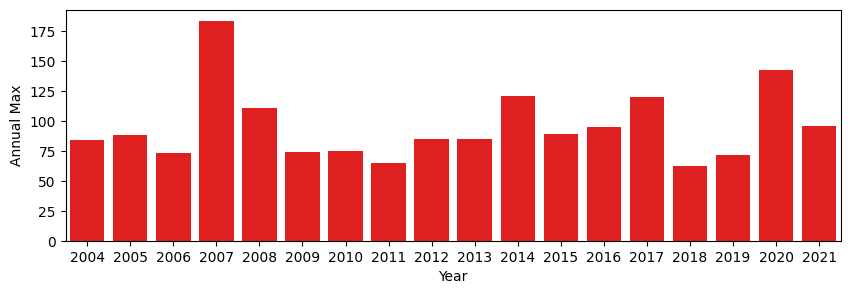

In [ ]:
plt.figure(figsize=(10,3))
sns.barplot(data=df,x='Year',y='Annual Max',color='red')

# **Data Eligibility Testing**

**RAPS (Rescaled Adjusted Partial Sums)** is a statistical method for identifying changes in trend or stationarity in time series data.

Q_per_n = 0.698 < Q95_bnd = 1.204 (95%) ACCEPTED
R_per_n = 0.962 < R95_bnd = 1.4 (95%) ACCEPTED


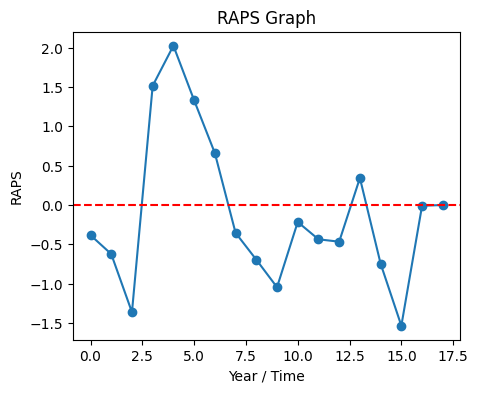

,Year,Annual Max,sk*,sk**,|sk**|
0,2004,83.9,-11.727778,-0.394153,0.394153
1,2005,88.3,-7.327778,-0.246276,0.246276
2,2006,73.0,-22.627778,-0.760486,0.760486
3,2007,183.7,88.072222,2.959975,2.959975
4,2008,111.2,15.572222,0.523359,0.523359
5,2009,74.4,-21.227778,-0.713434,0.713434
6,2010,75.1,-20.527778,-0.689908,0.689908
7,2011,64.6,-31.027778,-1.042797,1.042797
8,2012,85.2,-10.427778,-0.350462,0.350462
9,2013,84.9,-10.727778,-0.360544,0.360544


In [ ]:
def RAPS (df):
  df_raps = df.copy()
  n = len(df_raps)
  sum_data = np.sum(df_raps['Annual Max'])
  mean_data = np.mean(df_raps['Annual Max'])
  std_data = np.std(df_raps['Annual Max'])

  df_raps['sk*'] = df_raps['Annual Max'] - mean_data
  df_raps['sk**'] = df_raps['sk*']/std_data
  df_raps['|sk**|'] = np.abs(df_raps['sk**'])

  sk_min = np.min(df_raps['sk**'])
  sk_max = np.max(df_raps['sk**'])
  R = sk_max - sk_min
  Q = np.max(df_raps['|sk**|'])

  Q_per_n = round(Q/(n**0.5),3)
  R_per_n = round(R/(n**0.5),3)

  N_values = np.array([10, 20, 30, 40, 50, 100, np.inf])
  Q95_values = np.array([1.14, 1.22, 1.24, 1.26, 1.27, 1.29, 1.36])  # example for 95% control
  R95_values = np.array([1.28, 1.43, 1.5, 1.53, 1.55, 1.62, 1.75])

  Q95_bnd = np.interp(n, N_values, Q95_values)
  R95_bnd = np.interp(n, N_values, R95_values)

  if Q_per_n < Q95_bnd:
    print(f'Q_per_n = {Q_per_n} < Q95_bnd = {Q95_bnd} (95%) ACCEPTED')
  else:
    print(f'Q_per_n = {Q_per_n} > Q95_bnd = {Q95_bnd} (95%) NOT ACCEPTED')

  if R_per_n < R95_bnd:
    print(f'R_per_n = {R_per_n} < R95_bnd = {R95_bnd} (95%) ACCEPTED')
  else:
    print(f'R_per_n = {R_per_n} > R95_bnd = {R95_bnd} (95%) NOT ACCEPTED')

  # Step 1: Rata-rata dan standar deviasi
  sigma = np.std(df_raps['Annual Max'], ddof=1)

  # Step 2: Hitung S_k (Adjusted Partial Sum)
  S_k = np.cumsum(df_raps['sk*'])

  # Step 3: Hitung RAPS
  R_k = S_k / sigma

  # Plot
  plt.figure(figsize=(5,4))
  plt.plot(R_k, marker='o', linestyle='-')
  plt.axhline(0, color='red', linestyle='--')
  plt.title('RAPS Graph')
  plt.xlabel('Year / Time')
  plt.ylabel('RAPS')
  plt.show()

  return df_raps

RAPS(df)

Trendlessness Test

In [105]:
from scipy.stats import t
def Trendlessness (df):
  df_trendless = df.copy()
  n = len(df)
  df_trendless['rank'] = range(1, len(df_trendless) + 1)
  df_trendless['rainfall_ranking'] = sorted(df_trendless['Annual Max'],reverse=True)
  df_trendless['Rt'] = df_trendless['rainfall_ranking'].map(df_trendless.set_index('Annual Max')['rank'])
  df_trendless['dt2'] = (df_trendless['rank'] - df_trendless['Rt'])**2
  count = df_trendless['dt2'].sum()
  kp = 1-((6*count)/((n**3)-n))
  t_stat = round(kp*(np.sqrt((n-2)/(1-(kp**2)))),3)

  ddof = n - 2 # Degrees of Freedom
  alpha = 0.05 # level of significance

  t_critical = round(t.ppf(1-(alpha/2),ddof),3)

  if t_stat < t_critical:
    print(f't = {t_stat} < tc = {t_critical} (5%) Trendlessness = ACCEPTED')
  else:
    print(f't = {t_stat} > tc = {t_critical} (5%) Trend = NOT ACCEPTED')
  return df_trendless
Trendlessness(df)

t = -0.546 < tc = 2.12 (5%) Trendlessness = ACCEPTED


,Year,Annual Max,rank,rainfall_ranking,Rt,dt2
0,2004,83.9,1,183.7,4,9
1,2005,88.3,2,142.3,17,225
2,2006,73.0,3,121.0,11,64
3,2007,183.7,4,120.4,14,100
4,2008,111.2,5,111.2,5,0
5,2009,74.4,6,95.9,18,144
6,2010,75.1,7,94.7,13,36
7,2011,64.6,8,88.9,12,16
8,2012,85.2,9,88.3,2,49
9,2013,84.9,10,85.2,9,1


Inlier-Outlier Test

In [103]:
def Outlier_test (df):
  df_outlier = df.copy()
  n = len(df_outlier)
  df_outlier['ln x'] = round(np.log(df_outlier['Annual Max']),2)
  avg_ln = np.mean(df_outlier['ln x'])
  skew_ln = df_outlier['ln x'].skew()
  std_ln = np.std(df_outlier['ln x'])
  # Given
  n_data = [
      10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
      24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50,
      60, 70, 80, 90, 100, 120, 140
  ]
  # Given
  kn_values = [
      2.036, 2.080, 2.134, 2.178, 2.213, 2.247, 2.279, 2.309, 2.338, 2.365,
      2.390, 2.415, 2.438, 2.467, 2.468, 2.502, 2.532, 2.560, 2.586, 2.610,
      2.661, 2.682, 2.701, 2.719, 2.736, 2.750, 2.804,
      2.837, 2.867, 2.893, 2.918, 2.940, 3.078, 3.129
  ]

  Kn = np.interp(n, n_data, kn_values)
  Xh = round(np.exp(avg_ln+Kn*std_ln),1)
  Xl = round(np.exp(avg_ln-Kn*std_ln),1)

  # Filter for Upper Bound
  above_upper_bound = df_outlier[df_outlier['Annual Max'] > Xh]
  # Filter for Lower Bound
  below_lower_bound = df_outlier[df_outlier['Annual Max'] < Xl]

  # Result
  print("Data above the upper limit (Xh):")
  print(above_upper_bound)

  print("\nData below the lower limit (Xl):")
  print(below_lower_bound)
  return df_outlier
Outlier_test(df)

Data above the upper limit (Xh):
   Year  Annual Max  ln x
3  2007       183.7  5.21

Data below the lower limit (Xl):
Empty DataFrame
Columns: [Year, Annual Max, ln x]
Index: []


,Year,Annual Max,ln x
0,2004,83.9,4.43
1,2005,88.3,4.48
2,2006,73.0,4.29
3,2007,183.7,5.21
4,2008,111.2,4.71
5,2009,74.4,4.31
6,2010,75.1,4.32
7,2011,64.6,4.17
8,2012,85.2,4.45
9,2013,84.9,4.44


Homogenenity Test (F-test & t-test)

In [104]:
from scipy.stats import f
from scipy.stats import t
def Homogen_test (df):
  df_homogen = df.copy()
  n = len(df_homogen)
  n_half = int(n/2)
  N1 = df_homogen['Annual Max'][:n_half]
  N2 = df_homogen['Annual Max'][n_half:]
  n_N1 = len(N1)
  n_N2 = len(N2)
  avg_N1 = np.mean(N1)
  avg_N2 = np.mean(N2)
  std_N1 = np.std(N1)
  std_N2 = np.std(N2)
  ddof_1 = n_N1 - 1
  ddof_2 = n_N2 - 1

  alpha = 0.05 # level of significance

  # F-Test
  F_stat = round((np.var(N1)/np.var(N2)),3)
  F_critical = round(f.ppf(1-(alpha/2),n_N1,n_N2),3)
  if F_stat < F_critical:
    print(f'F_stat = {F_stat} < F_critical = {F_critical} (5%) ACCEPTED')
    print('homogen')
  else:
    print(f'F_stat = {F_stat} > F_critical = {F_critical} (5%) NOT ACCEPTED')
    print('Non-homogen')

  # t-test
  sigma = np.sqrt(((n_N1*std_N1**2)+(n_N2*std_N2**2))/(n_N1+n_N2-2))
  t_stat = round((avg_N1-avg_N2)/((sigma*np.sqrt(1/n_N1+1/n_N2))),3)
  ddof_df = n_N1 + n_N2 - 2
  t_critical = round(t.ppf(1-(alpha/2),ddof_df),3)
  if t_stat < t_critical:
    print(f't_stat = {t_stat} < t_critical = {t_critical} (5%) ACCEPTED')
    print('homogen')
  else:
    print(f't_stat = {t_stat} > t_critical = {t_critical} (5%) NOT ACCEPTED')
    print('Non-homogen')

Homogen_test(df)

F_stat = 2.022 < F_critical = 4.026 (5%) ACCEPTED
homogen
t_stat = -0.318 < t_critical = 2.12 (5%) ACCEPTED
homogen
